In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.io import read_video
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MovingMNIST

import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
!pip install av

In [3]:
class ConvolutionBasedInflationBlock(nn.Module):
    def __init__(self, dim, dim_out=3, spatial_layers=3, activation='relu'):
        super().__init__()

        # Pretrained Spatial Layer(s)
        self.pretrained_spatial_layers = nn.ModuleList([
            nn.Conv3d(dim, dim, kernel_size=(1, 3, 3), padding=(0, 1, 1))
            for _ in range(spatial_layers)
        ])

        # 2D Convolution
        self.conv2d = nn.Conv3d(dim, dim_out, kernel_size=(1, 3, 3), padding=(0, 1, 1))

        # 1D Convolution
        self.conv1d = nn.Conv3d(dim_out, dim_out, kernel_size=(3, 1, 1), padding=(1, 0, 0))

        # Normalization layers
        self.norm1 = nn.LayerNorm(dim_out)
        self.norm2 = nn.LayerNorm(dim_out)

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Linear Projection
        self.linear_projection = nn.Linear(dim_out, dim_out)

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)

        # Pretrained Spatial Layer(s)
        for layer in self.pretrained_spatial_layers:
            x = layer(x)

        # 2D Convolution
        x = self.conv2d(x)

        # Norm + activation
        x = x.permute(0, 2, 3, 4, 1)  # (B, T, H, W, C)
        x = self.norm1(x)
        x = self.activation(x)
        x = x.permute(0, 4, 1, 2, 3)  # (B, C, T, H, W)

        # 1D Convolution
        x = self.conv1d(x)

        # Norm + activation
        x = x.permute(0, 2, 3, 4, 1)  # (B, T, H, W, C)
        x = self.norm2(x)
        x = self.activation(x)

        # Linear Projection
        x = self.linear_projection(x)

        # Return to original shape
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)

        return x

In [4]:
class AttentionBasedInflationBlock(nn.Module):
    def __init__(self, dim, num_heads=9, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.pretrained_spatial_layers = nn.ModuleList([
            nn.Conv3d(dim, dim, kernel_size=(1, 3, 3), padding=(0, 1, 1))
            for _ in range(3)  # Assuming 3 pretrained spatial layers
        ])
        self.id_attention = nn.MultiheadAttention(dim, num_heads, dropout=attn_drop, batch_first=True)
        self.linear_projection = nn.Linear(dim, dim)

    def forward(self, x):
        # x shape: (B, T, C, H, W)

        # Permute to (B, C, T, H, W) for Conv3d layers
        x = x.permute(0, 2, 1, 3, 4)

        # Apply pretrained spatial layers
        for layer in self.pretrained_spatial_layers:
            x = layer(x)

        # Reshape for attention
        B, C, T, H, W = x.shape
        x = x.permute(0, 2, 3, 4, 1).reshape(B*T, H*W, C)

        # Apply ID Attention
        x, _ = self.id_attention(x, x, x)

        # Apply Linear Projection
        x = self.linear_projection(x)

        # Reshape back to (B, T, C, H, W)
        x = x.reshape(B, T, H, W, C).permute(0, 1, 4, 2, 3)

        return x

In [5]:
class SpatialResizing(nn.Module):
  def __init__(self, channels, transpose=False):
    super().__init__()

    if not transpose:
      self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    else:
      self.conv = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=2, padding=1, output_padding=1)

  def forward(self, x):
    b, t, c, h, w = x.shape

    out = []
    for i in range(t):
      out.append(self.conv(x[:, i]))

    return torch.stack(out, dim=1)

In [6]:
class TemporalResizing(nn.Module):
    def __init__(self, time_dim, imgs_dims, transpose=False):
        super().__init__()
        self.transpose = transpose
        self.time_dim = time_dim
        self.conv_channels = imgs_dims[0] * imgs_dims[1] * imgs_dims[2]

        if not transpose:
            self.conv = nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, stride=2, padding=1)
        else:
            self.conv = nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        b, t, c, h, w = x.shape

        x = x.reshape(b, t, -1).permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)

        new_time = x.shape[1]
        x = x.view(b, new_time, c, h, w)

        return x

In [7]:
class MultiDimensionResizing(nn.Module):
  def __init__(self, channels, time_dim, imgs_dims, transpose=False):
    super().__init__()
    self.spatial_resize = SpatialResizing(channels, transpose)

    if not transpose:
      self.imgs_dims = tuple()
      self.imgs_dims += (channels, imgs_dims[0] // 2, imgs_dims[1] // 2)
    else:
      self.imgs_dims = tuple()
      self.imgs_dims += (channels, imgs_dims[0] * 2, imgs_dims[1] * 2)

    self.temporal_resize = TemporalResizing(time_dim, self.imgs_dims, transpose)

  def forward(self, x):
    spatial = self.spatial_resize(x)
    return self.temporal_resize(spatial)

In [8]:
# Batch size x Time x Colors x H x W
valid = torch.rand((64, 8, 3, 8, 8))

In [9]:
conv_inf = ConvolutionBasedInflationBlock(3, 32)
x = conv_inf(valid)

print("Conv", x.shape)

down = MultiDimensionResizing(32, 4, (8, 8), False)
x = down(x)

print("Down", x.shape)

inflation = AttentionBasedInflationBlock(32, num_heads=8)
x = inflation(x)

print("Inflation", x.shape)

up = MultiDimensionResizing(32, 2,  (4, 4), True)
x = up(x)

print("Up", x.shape)

conv_inf_2 = ConvolutionBasedInflationBlock(32, 3)
x = conv_inf_2(x)

print("Conv", x.shape)

Conv torch.Size([64, 8, 32, 8, 8])
Down torch.Size([64, 4, 32, 4, 4])
Inflation torch.Size([64, 4, 32, 4, 4])
Up torch.Size([64, 8, 32, 8, 8])
Conv torch.Size([64, 8, 3, 8, 8])


In [10]:
class Lumiere(nn.Module):
  def __init__(self, start_img_shape):
    super().__init__()

    self.inflantion_block_1 = ConvolutionBasedInflationBlock(1, 32)
    self.resizing_1_img_shape = (start_img_shape[0], start_img_shape[1])
    self.resizing_1 = MultiDimensionResizing(32, 4, self.resizing_1_img_shape, False)

    self.inflantion_block_2 = ConvolutionBasedInflationBlock(32, 64)
    self.resizing_2_img_shape = (self.resizing_1_img_shape[0] // 2, self.resizing_1_img_shape[1] // 2)
    self.resizing_2 = MultiDimensionResizing(64, 2, self.resizing_2_img_shape, False)

    self.attention = AttentionBasedInflationBlock(64, num_heads=8)

    self.resizing_3_img_shape = (self.resizing_2_img_shape[0] // 2, self.resizing_2_img_shape[1] // 2)
    self.resizing_3 = MultiDimensionResizing(64, 2, self.resizing_3_img_shape, True)
    self.inflantion_block_3 = ConvolutionBasedInflationBlock(64, 32)

    self.resizing_4_img_shape = (self.resizing_3_img_shape[0] * 2, self.resizing_3_img_shape[1] * 2)
    self.resizing_4 = MultiDimensionResizing(32, 4, self.resizing_4_img_shape, True)
    self.inflantion_block_4 = ConvolutionBasedInflationBlock(32, 1)

  def forward(self, x):
    residual_1 = self.inflantion_block_1(x)
    x = self.resizing_1(residual_1.clone())

    residual_2 = self.inflantion_block_2(x)
    x = self.resizing_2(residual_2.clone())

    x = self.attention(x)

    x = self.resizing_3(x)
    x += residual_2

    x = self.inflantion_block_3(x)

    x = self.resizing_4(x)
    x += residual_1

    x = self.inflantion_block_4(x)

    return x

In [11]:
def add_gaussian_noise(tensor, mean=0, sigma=0.05):
    noise = torch.randn_like(tensor) * sigma + mean
    noisy_tensor = tensor + noise
    noisy_tensor = torch.clamp(noisy_tensor, 0.0, 1.0)
    return noisy_tensor

In [12]:
def display_images_from_tensor(video_tensor, num_images=30):
    assert len(video_tensor.shape) == 4, "Tensor should have shape (T, C, H, W)"

    T, C, H, W = video_tensor.shape

    num_images = min(num_images, T)

    fig, axes = plt.subplots(5, 6, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_images):
        frame = video_tensor[i].permute(1, 2, 0).numpy()

        ax = axes[i]
        ax.imshow(frame)
        ax.axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
dataset = MovingMNIST(
    root='./data',
    split='train',
    download=False,
    transform=transforms.Compose([
        transforms.Resize((16, 16)),
    ])
)

In [14]:
moving_mnist = DataLoader(dataset, batch_size=32)

In [15]:
moving_mnist = next(iter(moving_mnist))
moving_mnist.shape

torch.Size([32, 10, 1, 16, 16])

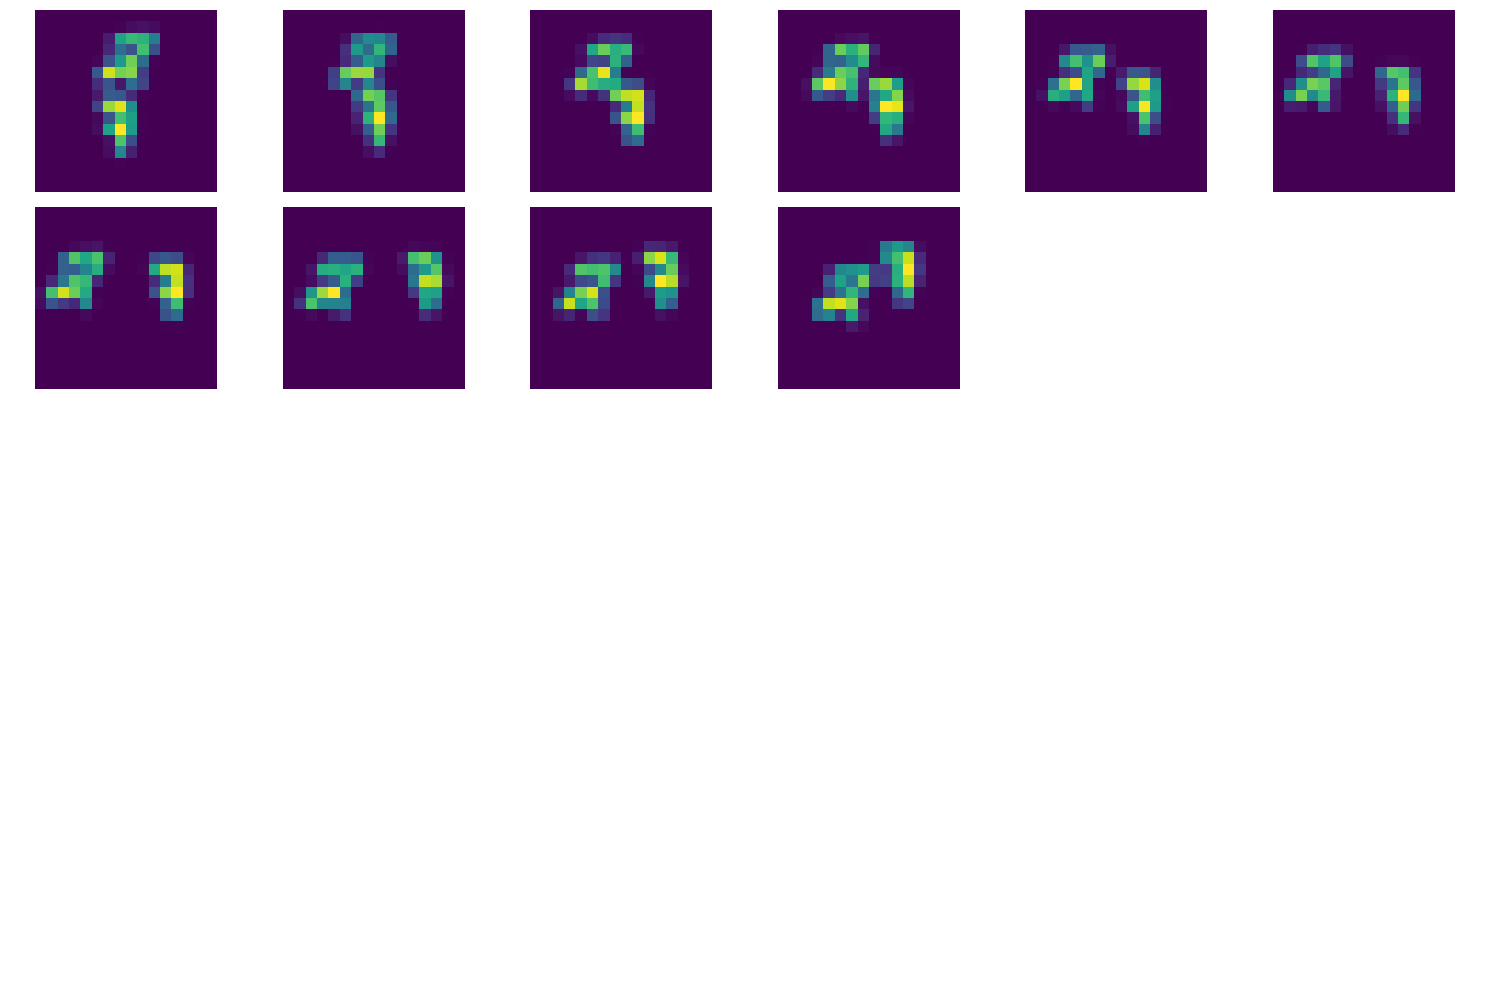

In [16]:
display_images_from_tensor(moving_mnist[0])

In [ ]:
mnist_model = Lumiere((32, 32))
valid = mnist_model(moving_mnist[0])
valid.shape

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, dataset_len, video_paths, labels, transform, read_video_kwargs):
      self.dataset_len = dataset_len
      self.video_paths = video_paths
      self.labels = labels
      self.transform = transform
      self.read_video_kwargs = read_video_kwargs

    def __len__(self):
      return self.dataset_len

    def __getitem__(self, idx):
      video, _, _ = read_video(self.video_paths[idx], **self.read_video_kwargs)
      label = self.labels[idx]

      video = torch.stack([self.transform(frame).float() / 255 for frame in video])
      return video, label

In [57]:
dataset_len = 1
video_paths = ["/content/2308576-hd_1920_1080_30fps.mp4"]
labels = ["example"]
transform = transforms.Resize((16, 16))

read_video_kwargs = {
    "pts_unit": "sec",
    "end_pts": 3,
    "output_format": "TCHW"
}

video_dataset = VideoDataset(dataset_len, video_paths, labels, transform, read_video_kwargs)
dataloader = DataLoader(video_dataset, batch_size=64)

In [58]:
video, label = next(iter(dataloader))
video.shape

torch.Size([1, 90, 3, 16, 16])

In [59]:
model = Lumiere((16, 16))
valid = model(video[:, :88, :, :, :])
valid.shape

torch.Size([1, 88, 3, 16, 16])

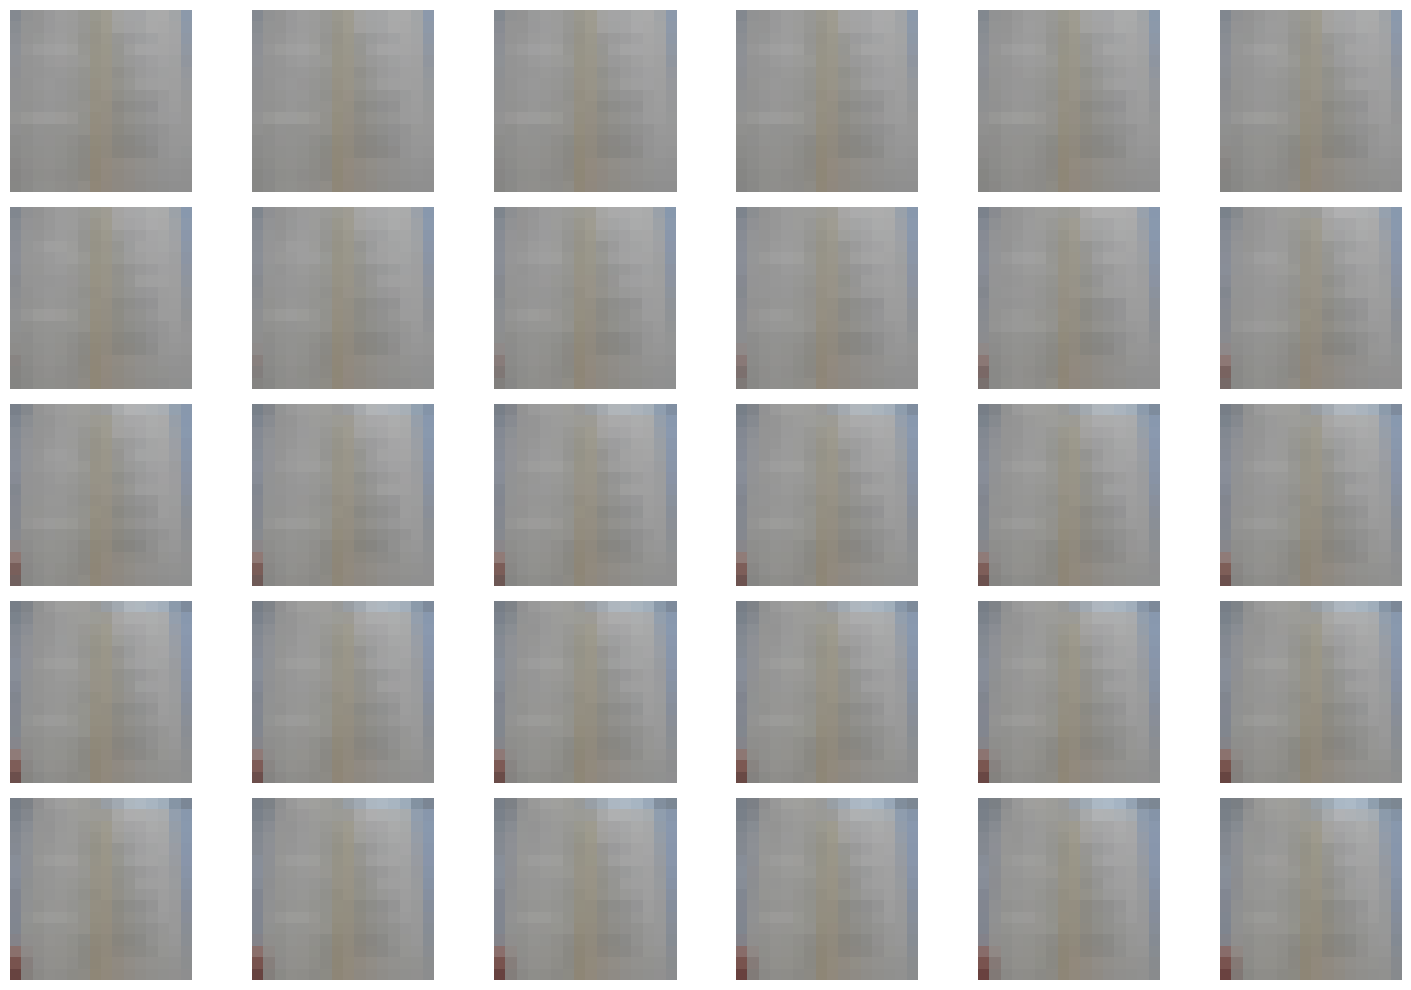

In [61]:
display_images_from_tensor(video[0])

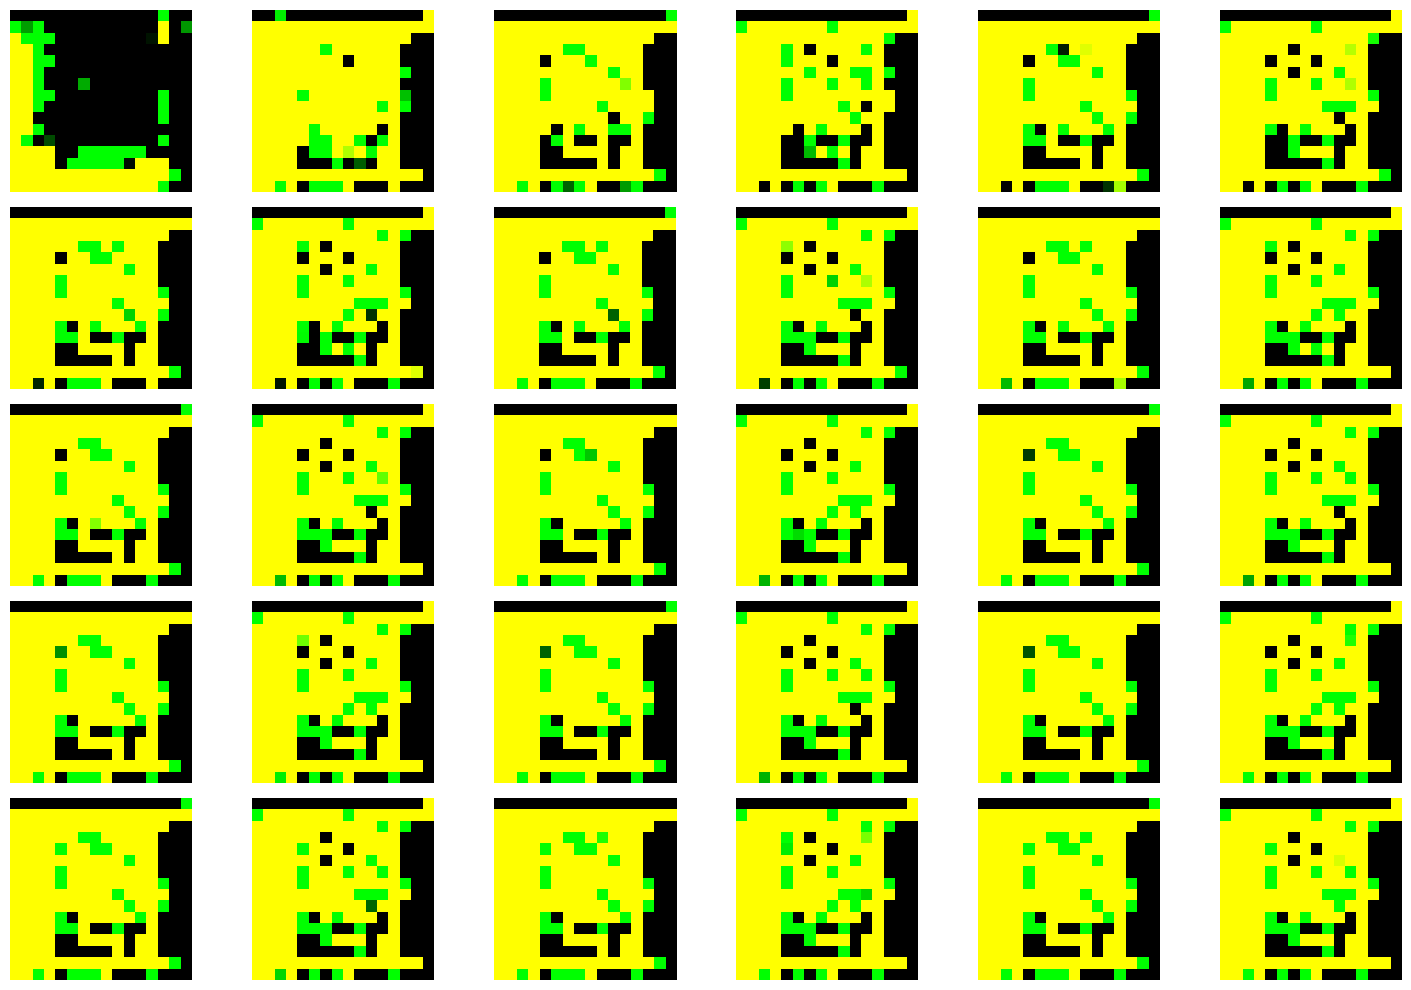

In [60]:
display_images_from_tensor(valid[0].detach() * 255)